# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]


In [3]:
y.shape

(506,)

In [4]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) =
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [5]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

32.88103715095578

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$.

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [17]:
def compute_bias_variance(regressor, X, y, num_runs=1000):
    oob_predictions = np.zeros((y.size, num_runs))
    oob_predictions_count = np.zeros(y.size)

    for i_run in range(num_runs):
        indices = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
        oob_indices = np.setdiff1d(range(X.shape[0]), indices, assume_unique=True)

        X_train, y_train = X[indices], y[indices]
        X_oob, y_oob = X[oob_indices], y[oob_indices]

        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_oob)

        oob_predictions[oob_indices, i_run] = y_pred
        oob_predictions_count[oob_indices] += 1

    valid_oob_predictions = oob_predictions_count > 0
    mean_oob_predictions = np.zeros(y.size)
    mean_oob_predictions[valid_oob_predictions] = np.sum(oob_predictions[valid_oob_predictions], axis=1) / oob_predictions_count[valid_oob_predictions]
    y_oob_true = y[valid_oob_predictions]
    bias = np.mean((mean_oob_predictions[valid_oob_predictions] - y_oob_true) ** 2)
    variance = np.mean([np.var(oob_predictions[idx, :int(count)], ddof=1) if count > 1 else 0 for idx, count in enumerate(oob_predictions_count)])
    mse = np.mean((oob_predictions[valid_oob_predictions] - y_oob_true.reshape(-1, 1)) ** 2)

    return bias, variance, mse

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
regressor_lr = LinearRegression()
regressor_dt = DecisionTreeRegressor()
regressor_rf = RandomForestRegressor()


In [7]:
bias_lr, variance_lr, mse_lr = compute_bias_variance(regressor_lr, X,y)
bias_dt, variance_dt, mse_dt = compute_bias_variance(regressor_dt, X,y)
bias_rf, variance_rf, mse_rf = compute_bias_variance(regressor_rf, X,y)
print(f'Разложение для линрега: bias - {bias_lr}, variance - {variance_lr}, mse - {mse_lr}')
print(f'Разложение для дерева: bias - {bias_dt}, variance - {variance_dt}, mse - {mse_dt}')
print(f'Разложение для рандом фореста: bias - {bias_rf}, variance - {variance_rf}, mse - {mse_rf}')

Разложение для линрега: bias - 23.70161358842144, variance - 132.50620540592257, mse - 383.51711347138735
Разложение для дерева: bias - 10.065501019193023, variance - 139.67268485209524, mse - 382.6117851976285
Разложение для рандом фореста: bias - 10.727435206179562, variance - 134.45366746071738, mse - 379.36639545422145


__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ В полученных результатах есть несколько интересных наблюдений:

Смещение для линейной регрессии  выше, чем для дерева и RF, тк они имеют меньшую систематическую ошибку, что может быть связано с их способностью выявлять нелинейные зависимости. Значения разброса достаточно близки друг к другу, это показывает, что все  модели достаточно чувствительны к изменениям в тренировочных данных. Значение мсе для всех моделей примерно одинаково высоко (меньше всего у RF). RF показывает лучшую обобщающую способность по сравнению с линейной регрессией и деревом, так как он обладает меньшим смещением и, по сравнению с деревом, немного меньшим разбросом. 

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__  Бэггинг должен приводить к снижению разброса и повышению обобщающей способности. Мой эксперимент привел к тому, что для всех трех моделей бэггинг не привел к ожидаемому снижению разброса. Возможные это связано с тем что:

1) Количество моделей, использованных в бэггинге, недостаточно велико, чтобы достичь значительного снижения разброса.
2) Модели, используемые в бэггинге, сильно коррелируют друг с другом, что уменьшает эффективность бэггинга в снижении разброса.
3) Выборка не очень разнообразная

In [9]:
def bagging_ensemble_bias_variance(regressors, X, y, num_bags=10, num_runs=1000):
    biases = []
    variances = []
    mses = []
    
    for regressor in regressors:
        bagging_regressor = BaggingRegressor(
            base_estimator=regressor,
            n_estimators=num_bags,
            bootstrap=True,
            oob_score=False,
            n_jobs=-1
        )
        bias, variance, mse = compute_bias_variance(bagging_regressor, X, y, num_runs)
        
        biases.append(bias)
        variances.append(variance)
        mses.append(mse)
    
    return biases, variances, mses

regressors = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
biases, variances, mses = bagging_ensemble_bias_variance(regressors, X, y, num_bags=10, num_runs=100)

for i, regressor in enumerate(regressors):
    print(f"{regressor.__class__.__name__} - Bias: {biases[i]}, Variance: {variances[i]}, MSE: {mses[i]}")

for i, regressor in enumerate(regressors):
    _, base_variance, _ = compute_bias_variance(regressor, X, y, num_runs=100)
    reduction_factor = base_variance / variances[i]
    #на сколько бэггинг повышает/понижает разброс по сравнению с использованием одной модели
    print(f"{regressor.__class__.__name__} - Reduction factor in variance: {reduction_factor}") 




LinearRegression - Bias: 23.79752704317528, Variance: 131.87584820845234, MSE: 383.20756525259407
DecisionTreeRegressor - Bias: 10.465485489107033, Variance: 136.13559314424052, MSE: 379.42280427667987
RandomForestRegressor - Bias: 11.981940518297266, Variance: 133.02786018077597, MSE: 379.1008164779785
LinearRegression - Reduction factor in variance: 0.9965572856439081
DecisionTreeRegressor - Reduction factor in variance: 1.0225832855726118
RandomForestRegressor - Reduction factor in variance: 1.0113335712339373


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [12]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, ax=None, title=""):
    test_indices = np.random.choice(len(X), num_test_objects, replace=False)
    X_test = X[test_indices]
    y_test = y[test_indices]

    train_indices = np.setdiff1d(np.arange(len(X)), test_indices)
    X_train = X[train_indices]
    y_train = y[train_indices]

    bootstrap_predictions = []
    for _ in range(num_runs):
        bootstrap_indices = np.random.choice(len(X_train), len(X_train), replace=True)
        X_bootstrap = X_train[bootstrap_indices]
        y_bootstrap = y_train[bootstrap_indices]

        regressor.fit(X_bootstrap, y_bootstrap)
        predictions = regressor.predict(X_test)
        bootstrap_predictions.append(predictions)

    colors = plt.cm.get_cmap("tab10").colors

    for i in range(num_test_objects):
        x = np.arange(num_runs)
        y = [pred[i] for pred in bootstrap_predictions]

        ax.scatter(x, y, color=colors[i], alpha=0.3)
        ax.scatter(i, y_test[i], color="black", label="True value" if i == 0 else "")

    ax.set_xlabel("Prediction number")
    ax.set_title(title)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

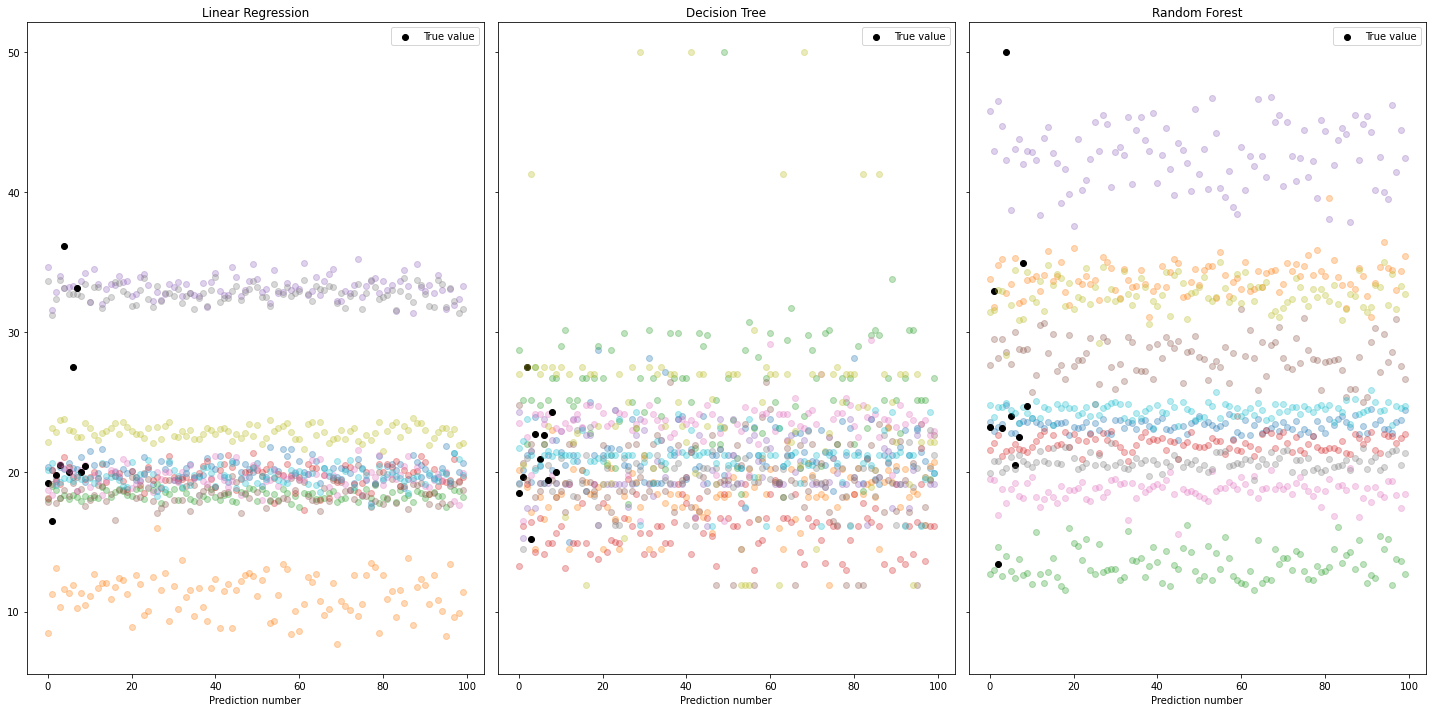

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
plot_predictions(regressor_lr, X, y,ax=axs[0],  title="Linear Regression")
plot_predictions(regressor_dt, X, y, ax=axs[1], title="Decision Tree")
plot_predictions(regressor_rf, X, y, ax=axs[2], title="Random Forest")

for ax in axs:
    ax.label_outer()
    ax.legend(loc="best")

plt.tight_layout()
plt.show();

__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

__Your answer here:__  Если предсказания распределены широко для определенного тестового объекта, это может указывать на большую нестабильность регрессора при разных обучающих наборах, а предсказания близки к черным точкам, это означает, что регрессор способен достаточно точно предсказывать значения на новых данных. В линейной регрессии и решающем дереве точки менее разбросаны на плоскости, чем в рандом форесте. Линейная регрессия характеризуется высоким смещением и низким разбросом (точки более сгруппированы, чем на остальных графиках). Решающее дерево характеризуется более низким смещением и высоким разбросом на графике. Для рандом фореста свойственно низкое смещение и на графике как будто виден высокий разброс.


### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

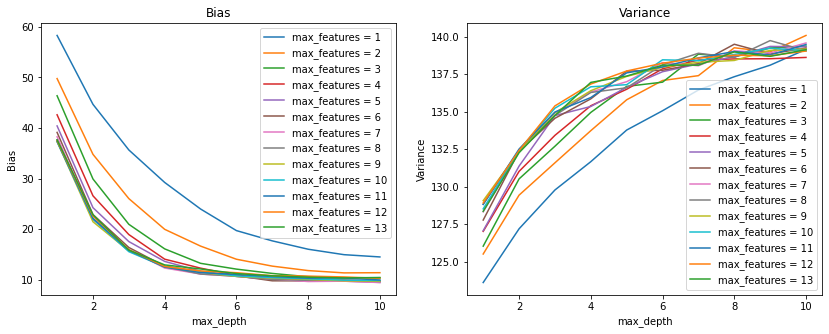

In [18]:
depths = range(1, 11)
features = range(1, X.shape[1]+1)
biases = np.zeros((len(depths), len(features)))
variances = np.zeros_like(biases)
for i, max_depth in enumerate(depths):
    for j, max_features in enumerate(features):
        regressor = DecisionTreeRegressor(max_depth=max_depth, max_features=max_features)
        bias, variance, _ = compute_bias_variance(regressor, X, y)
        biases[i, j] = bias
        variances[i, j] = variance

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for j, max_features in enumerate(features):
    plt.plot(depths, biases[:, j], label=f'max_features = {max_features}')
plt.title('Bias')
plt.xlabel('max_depth')
plt.ylabel('Bias')
plt.legend()

plt.subplot(1, 2, 2)
for j, max_features in enumerate(features):
    plt.plot(depths, variances[:, j], label=f'max_features = {max_features}')
plt.title('Variance')
plt.xlabel('max_depth')
plt.ylabel('Variance')
plt.legend()

plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

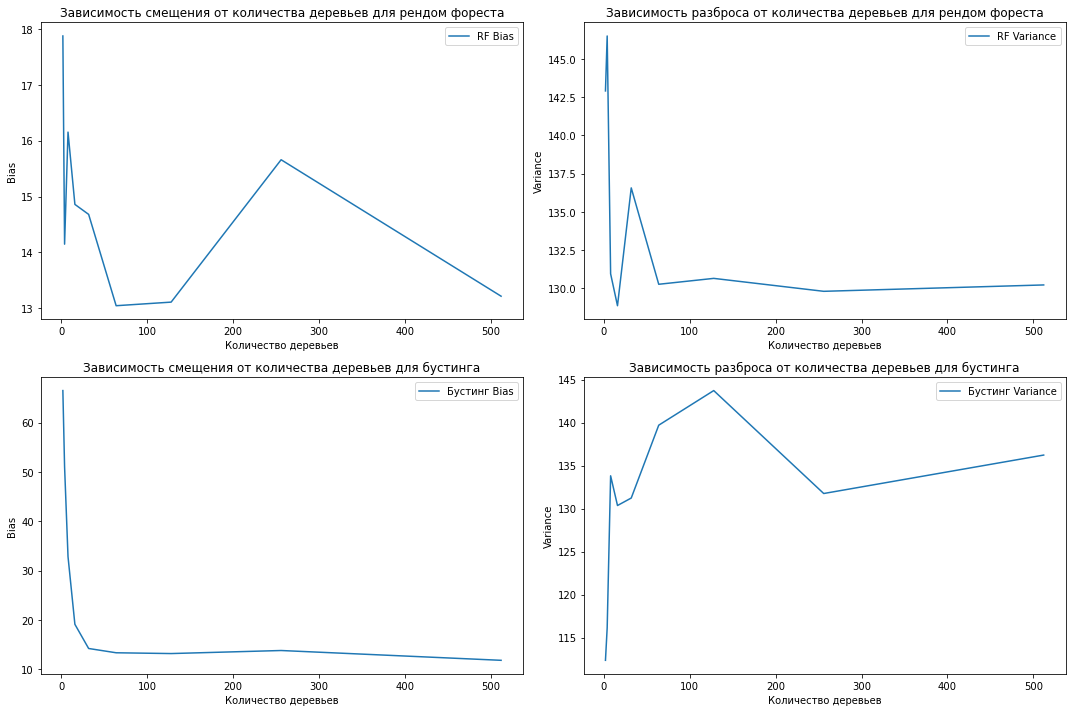

In [27]:
def plot_bias_variance_by_estimators(model_class, X, y, num_runs=100, estimators_grid=None):
    if estimators_grid is None:
        estimators_grid = 2 ** np.arange(1, 10)
    
    biases, variances, mses = [], [], []

    for n_estimators in estimators_grid:
        regressor = model_class(n_estimators=n_estimators)
        bias, variance, mse = compute_bias_variance(regressor, X, y, num_runs=num_runs)
        biases.append(bias)
        variances.append(variance)
        mses.append(mse)
    
    return biases, variances, mses


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

estimators_grid = 2 ** np.arange(1, 10)

biases_rf, variances_rf, mses_rf = plot_bias_variance_by_estimators(RandomForestRegressor, X_train, y_train, num_runs=10, estimators_grid=estimators_grid)

biases_gb, variances_gb, mses_gb = plot_bias_variance_by_estimators(GradientBoostingRegressor, X_train, y_train, num_runs=10, estimators_grid=estimators_grid)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axes[0, 0].plot(estimators_grid, biases_rf, label='RF Bias')
axes[0, 0].set_xlabel('Количество деревьев')
axes[0, 0].set_ylabel('Bias')
axes[0, 0].set_title('Зависимость смещения от количества деревьев для рендом фореста')
axes[0, 0].legend()

axes[0, 1].plot(estimators_grid, variances_rf, label='RF Variance')
axes[0, 1].set_xlabel('Количество деревьев')
axes[0, 1].set_ylabel('Variance')
axes[0, 1].set_title('Зависимость разброса от количества деревьев для рендом фореста')
axes[0, 1].legend()

axes[1, 0].plot(estimators_grid, biases_gb, label='Бустинг Bias')
axes[1, 0].set_xlabel('Количество деревьев')
axes[1, 0].set_ylabel('Bias')
axes[1, 0].set_title('Зависимость смещения от количества деревьев для бустинга')
axes[1, 0].legend()

axes[1, 1].plot(estimators_grid, variances_gb, label='Бустинг Variance')
axes[1, 1].set_xlabel('Количество деревьев')
axes[1, 1].set_ylabel('Variance')
axes[1, 1].set_title('Зависимость разброса от количества деревьев для бустинга')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

В бустинге, чем больше деревьев, тем меньше смещение, так как модель все лучше предсказывает наши таргеты, устраняя ошибки моделей на предыдущих шагах, однако чем больше деревьев, тем больше модель подстраивается под обучающую выборку и может показывать странные нехорошие результаты на новых данных. В случае RF увеличение числа деревьев ведёт к уменьшению разброса, поскольку решения, принимаемые на основе усреднения деревьев, меньше зависят от конкретных обучающих примеров. Мы можем ожидать, что с увеличением числа деревьев смещение для обеих моделей уменьшается, потому что модели становятся сложнее и лучше аппроксимируют обучающие данные (однако стоит подбирать гиперпараметры, потому что даже на графиках видно, что в случайном лесу смещение не убывает монотонно: сначала убывает, потом возрастает и снова убывает).

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__ вот так же как я провожу время сейчас, я начала зиму, только 23 дня назад, а вообще я не помню

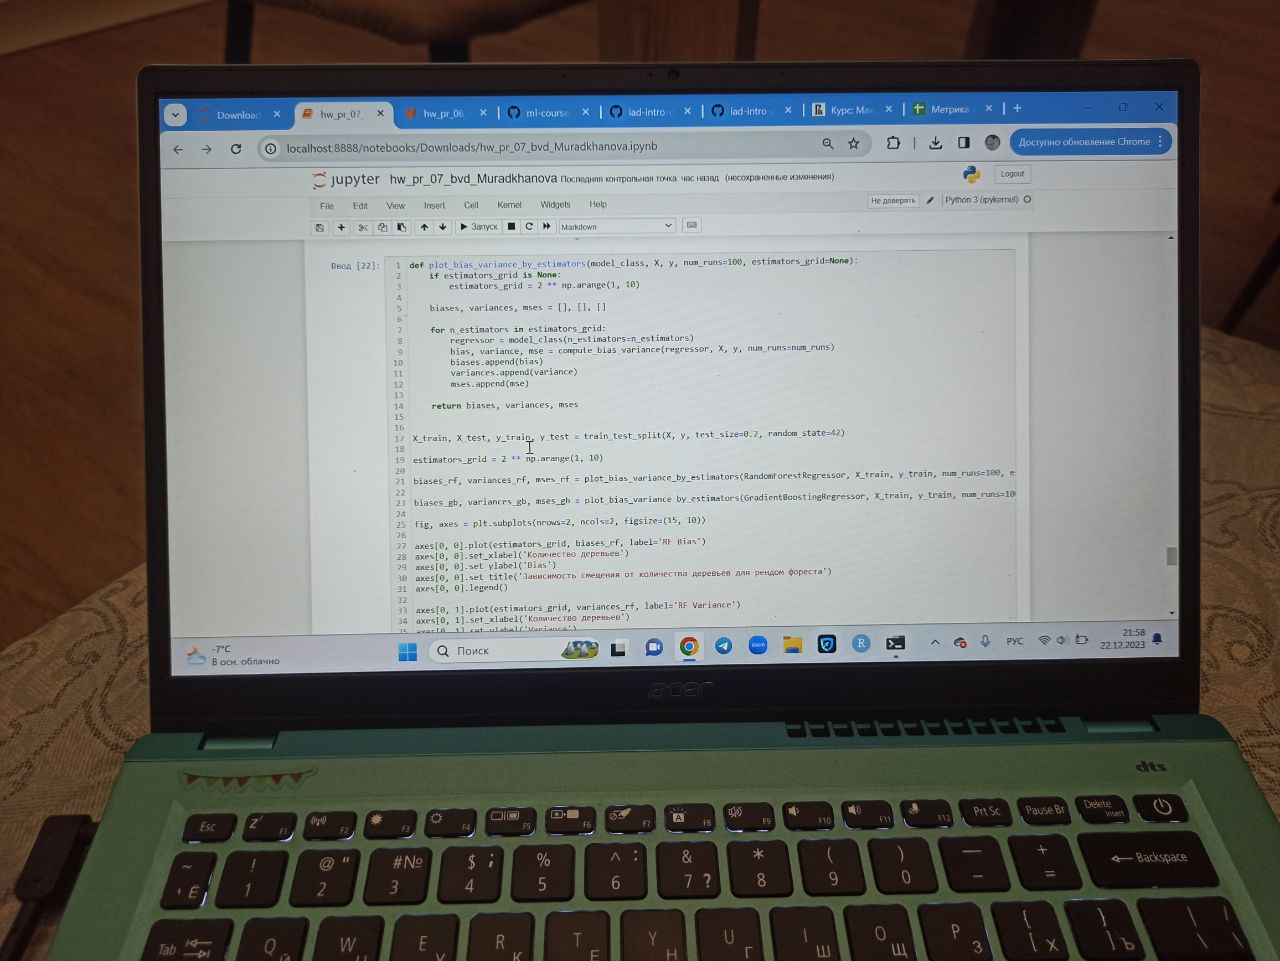

In [26]:
from IPython.display import Image
Image(r"C:\Users\murad\Downloads\как я провел эту зиму.jpg", width=520, height=440)

